# 3D analysis

In this tutorial, we present the basics steps for a 3D stacked analysis. The main aim is to perform a spectral and morphological analysis of a given source.
We are going to analyze a generic Galactic field of the internal Science Data Challenge of CTAO. The field is rich of sources, with growing complexity of their spectral and spatial properties.

Let's start with some basic imports:

In [1]:
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.datasets import MapDataset, Datasets
from gammapy.data import (
    DataStore,
    Observation,
    Observations,
)
from gammapy.estimators import ExcessMapEstimator
from gammapy.makers import (
    MapDatasetMaker, 
    SafeMaskMaker, 
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    Models,
)

Let's investigate the Galactic field centered at the coordinates Ra, Dec = 257.500000°, -46.0°. We select all the available observations inside a cone of radius 5°.

In [2]:
# we need to set the path of the IRF:
%env CALDB=../caldb/

env: CALDB=../caldb/


In [3]:
data_store = DataStore.from_dir("../output")

In [22]:
#source coordinates
l, b = 341.90669676 * u.deg, -3.62457011 * u.deg 
pointing = SkyCoord(l, b, frame="galactic")

In [23]:
selection = dict(
    type="sky_circle",
    frame="galactic",
    lon=pointing.galactic.l.deg,
    lat=pointing.galactic.b.deg,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [6]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])
print(observations[0])

Observation

	obs id            : 5000002225 
 	tstart            : 61884.22
	tstop             : 61884.24
	duration          : 1575.00 s
	pointing (icrs)   : 255.2 deg, -43.8 deg

	deadtime fraction : 0.0%



Now, we generate the 'stacked' dataset:

In [7]:
energy_axis = MapAxis.from_energy_bounds(0.012, 100.0, 8, unit="TeV")

geom = WcsGeom.create(
    skydir=(pointing.galactic.l.deg , pointing.galactic.b.deg),
    binsz=0.01,
    width=(5, 5),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.001, 40, 10, unit="TeV", name="energy_true"
)

In [8]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="my-dataset"
)

A number of sources is present in the field. This can affect significantly the estimates of the background and it implies therefore that we need to exclude these regions from the data, applying a mask. The source regions can be choosen manually or, more likely, from catalogues of known sources:

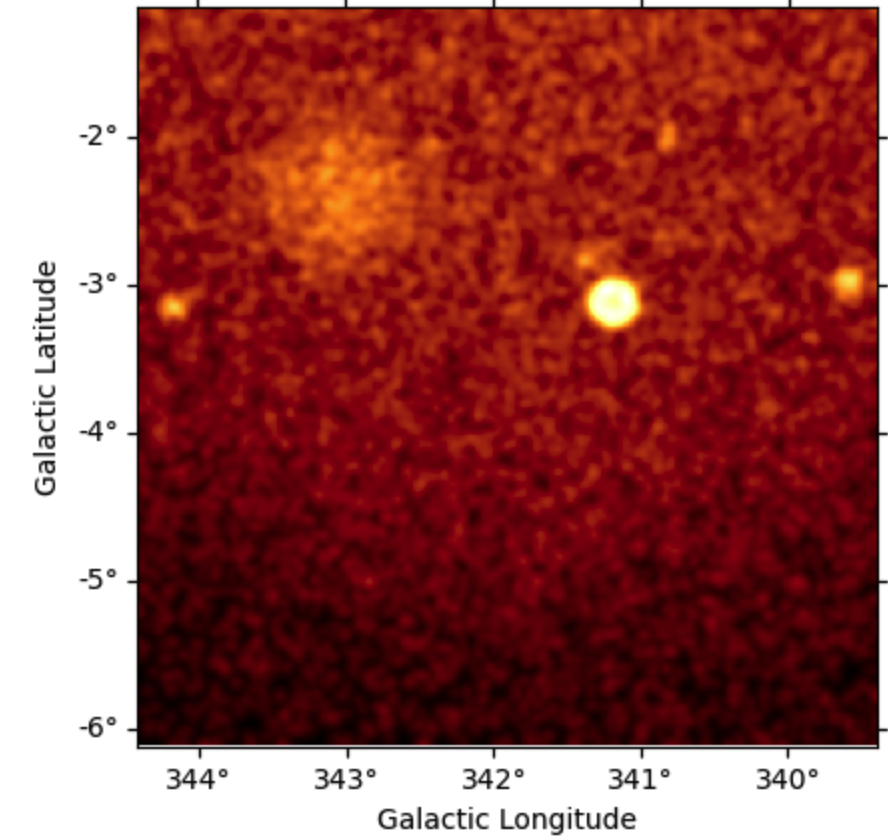

In [29]:
SkyCoord(254.7488674, -47.4768956, unit="deg", frame="icrs").galactic

<SkyCoord (Galactic): (l, b) in deg
    (339.58634079, -3.01718097)>

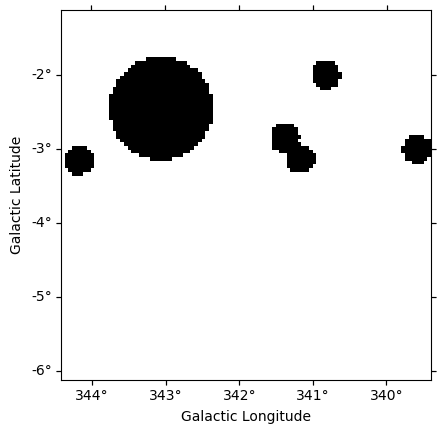

In [30]:
exclusion_src1 = CircleSkyRegion(
    center=SkyCoord(344.1646678, -3.16256952, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src2 = CircleSkyRegion(
    center=SkyCoord(343.05454002, -2.46546336, unit="deg", frame="galactic"),
    radius=0.7 * u.deg,
)
exclusion_src3 = CircleSkyRegion(
    center=SkyCoord(341.17287207, -3.14538304, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src4 = CircleSkyRegion(
    center=SkyCoord(341.38004212, -2.86952312, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src5 = CircleSkyRegion(
    center=SkyCoord(340.82287577, -2.01295808, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src6 = CircleSkyRegion(
    center=SkyCoord(339.58634079, -3.01718097, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)

exclusion_geom = WcsGeom.create(
    npix=(100, 100), binsz=0.05, skydir=pointing.galactic, proj="TAN", frame="galactic"
)

exclusion_mask = ~exclusion_geom.region_mask([exclusion_src1, exclusion_src2, exclusion_src3,
                                   exclusion_src4, exclusion_src5, exclusion_src6])
exclusion_mask.plot()
plt.show()

In [10]:
offset_max = 6 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max"], offset_max=offset_max
)

maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [11]:
for i, obs in enumerate(observations):
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.get_pointing_icrs(obs.tmid), width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"{i} of {len(observations)}, Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

print(stacked)

0 of 37, Background norm obs 5000002225: 1.16
1 of 37, Background norm obs 5000002226: 1.19
2 of 37, Background norm obs 5000002250: 1.07
3 of 37, Background norm obs 5000002251: 1.08
4 of 37, Background norm obs 5000002280: 1.07
5 of 37, Background norm obs 5000002307: 1.02
6 of 37, Background norm obs 5000002308: 1.28
7 of 37, Background norm obs 5000002404: 1.07
8 of 37, Background norm obs 5000002405: 1.08
9 of 37, Background norm obs 5000002436: 1.00
10 of 37, Background norm obs 5000002437: 1.11
11 of 37, Background norm obs 5000002459: 1.02
12 of 37, Background norm obs 5000002461: 0.90
13 of 37, Background norm obs 5000002635: 1.13
14 of 37, Background norm obs 5000002636: 1.20
15 of 37, Background norm obs 5000002652: 1.09
16 of 37, Background norm obs 5000002653: 1.08
17 of 37, Background norm obs 5000002666: 1.02
18 of 37, Background norm obs 5000002667: 2.00
19 of 37, Background norm obs 5000002723: 1.02
20 of 37, Background norm obs 5000002831: 1.05
21 of 37, Background no

Let's inspect the field:

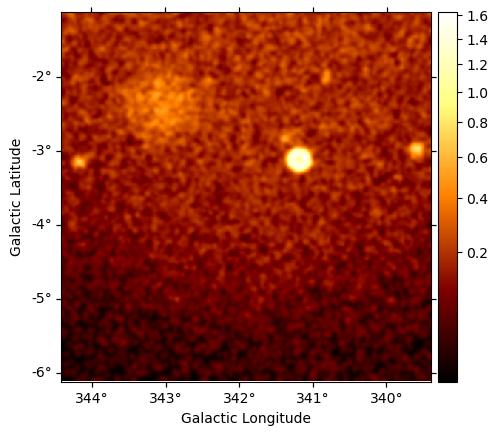

In [12]:
stacked.counts.sum_over_axes().smooth(0.03 * u.deg).plot(stretch="sqrt", add_cbar=True)
plt.show()

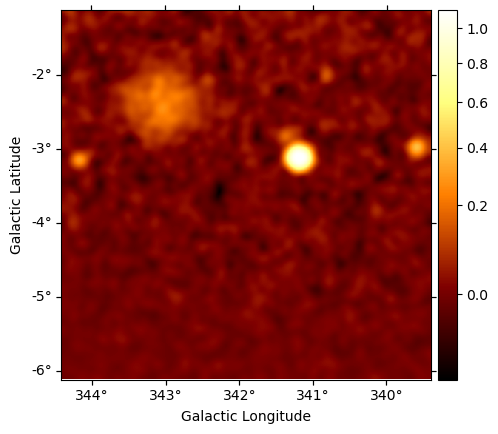

In [13]:
excess = stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True)
plt.show()

## 3D analysis of one source

The 3D analysis consists of a simultaneous fit of the spectral and spatial parameters of one or multiple sources. Here, we focus only on a single source, centered at the coordinates Ra, Dec = 254.7204743°, -47.4492570°. 
To perform the fit, we firstly need to define a model: we can try with a point-like morphology and a powerlaw spectral shape:

In [45]:
stacked.mask_fit = stacked.counts.geom.energy_mask(
    energy_min=0.05 * u.TeV, energy_max=None
)

#spatial_model = PointSpatialModel(
#    lon_0="254.7204743 deg", lat_0="-47.4492570 deg", frame="icrs"
#)
spatial_model = GaussianSpatialModel(
    lon_0="339.59620994 deg", lat_0="-2.98500599 deg", frame="galactic",
    sigma="0.1 deg"
)

spectral_model = PowerLawSpectralModel(
    index=2,
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
)
#spectral_model = ExpCutoffPowerLawSpectralModel(
#    index=2.0020e+00,
#    amplitude=5.1154e-13 * u.Unit("cm-2 s-1 TeV-1"),
#    reference=1.0 * u.TeV,
#    _lambda = "0.1 TeV-1"
#)

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="gc-source",
)

# FOR SIMPLICITY, WE ASSUME THE BACKGROUND IS WELL KNOWN AND CAN BE 
# TAKEN FROM THE IRF BKG MODEL:
bkg_model = FoVBackgroundModel(dataset_name=stacked.name)
bkg_model.spectral_model.norm.value = 1.0

models_stacked = Models([model, bkg_model])

stacked.models = models_stacked

Once the model is defined, we can fit the dataset with the Gammapy `Fit` class: 

In [46]:
# For simplicity we might freeze the coordinates:
#stacked.models.parameters["lon_0"].frozen = False
#stacked.models.parameters["lat_0"].frozen = False
stacked.models.parameters["lon_0"].frozen = True
stacked.models.parameters["lat_0"].frozen = True

fit = Fit(optimize_opts={"print_level": 2})
result = fit.run(datasets=[stacked])

I MnSeedGenerator Initial state: FCN =       271177.3632 Edm =       307.7026205 NCalls =     21
I VariableMetricBuilder Start iterating until Edm is < 0.0002 with call limit = 680
I VariableMetricBuilder    0 - FCN =       271177.3632 Edm =       307.7026205 NCalls =     21
I VariableMetricBuilder    1 - FCN =       270939.8781 Edm =       9.573569814 NCalls =     42
I VariableMetricBuilder    2 - FCN =       270893.4131 Edm =       29.74766678 NCalls =     57
I VariableMetricBuilder    3 - FCN =       270891.2521 Edm =       23.75430661 NCalls =     67
I VariableMetricBuilder    4 - FCN =       270882.4161 Edm =       1.014128333 NCalls =     77
I VariableMetricBuilder    5 - FCN =       270880.7367 Edm =       0.313929158 NCalls =     87
I VariableMetricBuilder    6 - FCN =       270879.2365 Edm =     0.03442878003 NCalls =     97
I VariableMetricBuilder    7 - FCN =       270879.2058 Edm =   0.0007822570794 NCalls =    107
I VariableMetricBuilder    8 - FCN =       270879.2051 Edm 

In [47]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 147
	total stat : 270879.21

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [48]:
display(models_stacked.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str14,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
gc-source,,index,1.9745e+00,,9.992e-02,nan,nan,False,False,,
gc-source,,amplitude,4.7844e-13,TeV-1 s-1 cm-2,8.449e-14,nan,nan,False,True,,
gc-source,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
gc-source,,lon_0,3.3960e+02,deg,0.000e+00,nan,nan,True,False,,
gc-source,,lat_0,-2.9850e+00,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,,
gc-source,,sigma,4.3331e-02,deg,4.734e-03,0.000e+00,nan,False,False,,
gc-source,,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,,
gc-source,,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,,
my-dataset-bkg,,norm,1.0862e+00,,6.013e-03,nan,nan,False,True,,


We can now inspect the residuals:

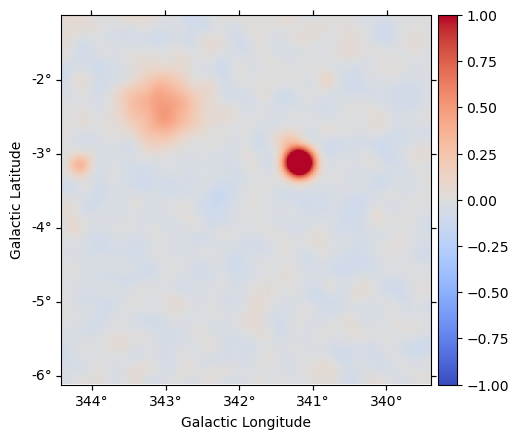

In [49]:
stacked.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-1, vmax=1)
plt.show()

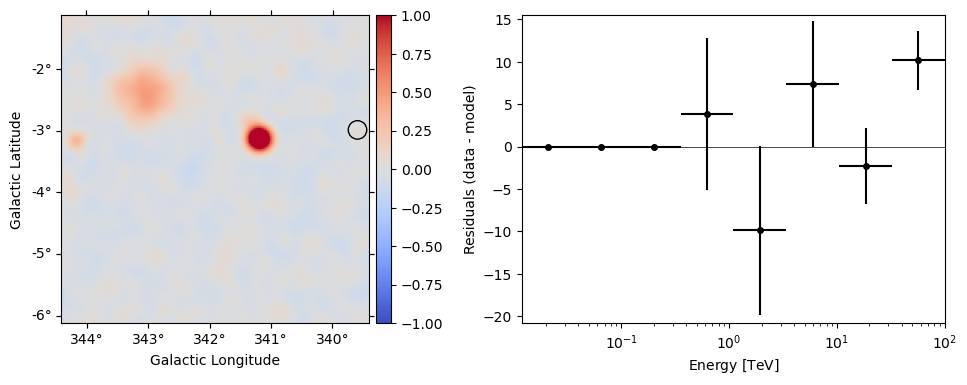

In [50]:
region = CircleSkyRegion(spatial_model.position.icrs, radius=0.15 * u.deg)
stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1),
    kwargs_spectral=dict(region=region),
)
plt.show()

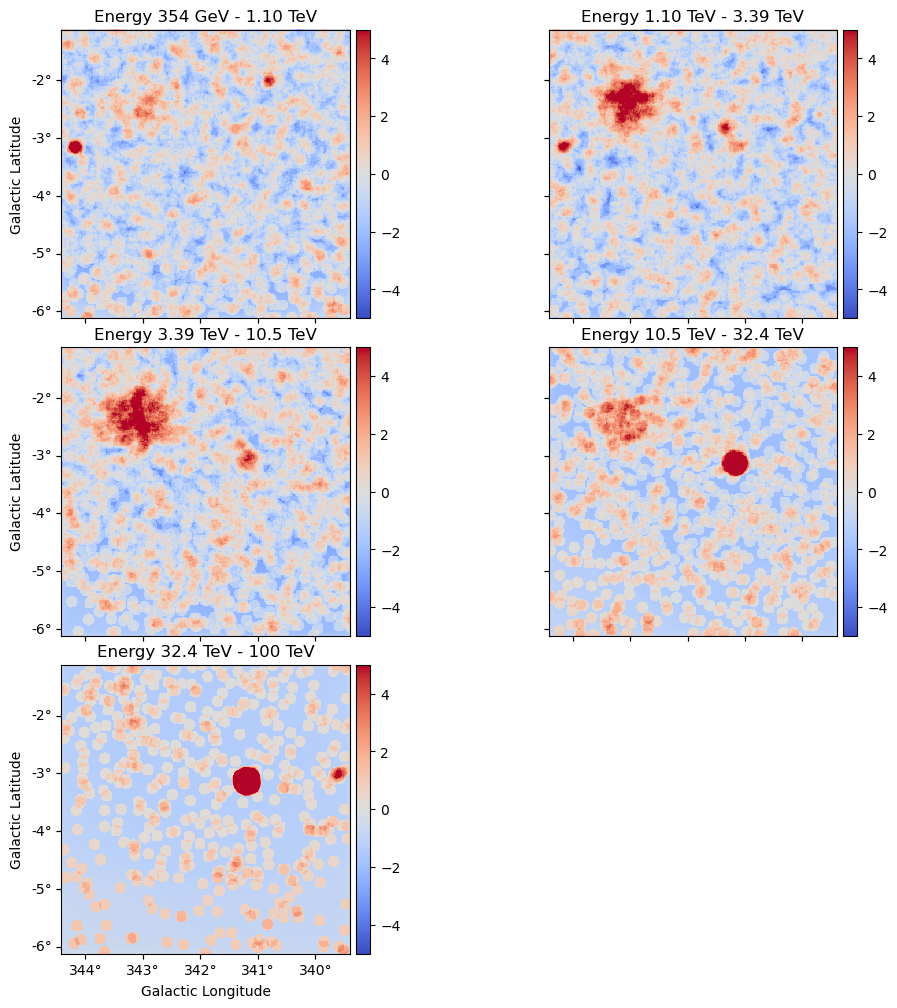

In [51]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.3, 1, 5, 10, 20, 100] * u.TeV,
)

result = estimator.run(stacked)
result["sqrt_ts"].plot_grid(
    figsize=(12, 12), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
)
plt.show()

## Open problems: 

1) Try to create a small catalogue of the sources in this field. Run a source detection, and for each significant source, perform a 3D analysis. List your results!
2) Open a catalogue of known gamma-ray sources and, when possible, associate the analyzed sources.

Some tips: 
- Set a significance threshold at 5 sigma and consider a minimum distance between detected sources of 0.15°;
- Assume a power-law spectral model for all the sources;
- Assume a gaussian morphology for all the sources (with ellipticity and angle fixed at the default values);
- Freeze the source position to speed up the fitting process;
- Assume the background is well known and take it from the IRF (i.e. use the `FoVBackgroundModel`);